## The sixth Lab-assignment (08/02/2022 11:59'AM' - 08/05/2022 11:59PM, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Q1 Task Decription (50 Points)

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from dmba import regressionSummary
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Your code

In [2]:
### You code here:

df_train = pd.read_csv('train_luc.csv')
df_test = pd.read_csv('test_luc.csv')
df_train.head()



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
print(df_train.isnull().sum().sum())
print(df_train.isna().sum().sum())
print(df_test.isnull().sum().sum())
print(df_test.isna().sum().sum())

0
0
0
0


In [4]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


<AxesSubplot:>

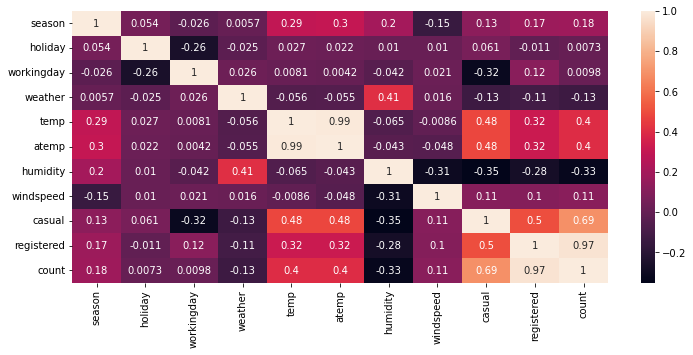

In [5]:
corr=df_train.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr,annot=True)

In [6]:
df_train['hour']=df_train['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time().hour)
df_train['month']=df_train['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date().month)
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9169,2012-12-16 19:00:00,4,0,0,1,14.76,17.425,93,8.9981,10,99,109,19,12
9170,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122,20,12
9171,2012-12-16 21:00:00,4,0,0,2,14.76,18.940,93,0.0000,14,92,106,21,12
9172,2012-12-16 22:00:00,4,0,0,2,16.40,20.455,82,12.9980,6,83,89,22,12


In [7]:
df_test['hour']=df_test['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time().hour)
df_test['month']=df_test['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date().month)
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013,0,1
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980,1,1
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979,2,1
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980,3,1
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981,4,1
...,...,...,...,...,...,...,...,...,...,...,...
1707,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,19,12
1708,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,20,12
1709,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,21,12
1710,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,22,12


In [8]:
df_train1=df_train.drop(['datetime'],axis=1)
df_train1

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9169,4,0,0,1,14.76,17.425,93,8.9981,10,99,109,19,12
9170,4,0,0,2,15.58,19.695,82,0.0000,14,108,122,20,12
9171,4,0,0,2,14.76,18.940,93,0.0000,14,92,106,21,12
9172,4,0,0,2,16.40,20.455,82,12.9980,6,83,89,22,12


In [9]:
X=df_train1.drop(['count'],axis=1)
y=df_train1['count']

In [10]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size=0.2)

In [11]:
rf = RandomForestRegressor(random_state=45,max_depth = 10, oob_score = True)
rf.fit(Xtrain,ytrain)

RandomForestRegressor(max_depth=10, oob_score=True, random_state=45)

In [12]:

score = cross_val_score(rf, Xtrain, ytrain, cv = 5)
score

array([0.99824394, 0.99892943, 0.99840223, 0.99796447, 0.99635272])

In [13]:
predy =rf.predict(Xtest)
predy

array([  2.9940625 , 135.45844896,  73.92968071, ..., 465.06287093,
       183.9159536 ,  93.50267737])

In [14]:
rf.score(Xtest,ytest)

0.9980980439000757

In [15]:
regressionSummary(ytest, rf.predict(Xtest))


Regression statistics

                      Mean Error (ME) : 0.4073
       Root Mean Squared Error (RMSE) : 7.8958
            Mean Absolute Error (MAE) : 3.0647
          Mean Percentage Error (MPE) : -0.1864
Mean Absolute Percentage Error (MAPE) : 1.9313


In [16]:
regg = LinearRegression()
regg.fit(Xtrain,ytrain)

LinearRegression()

In [17]:
predy =regg.predict(Xtest)
predy

array([  3., 136.,  72., ..., 470., 179.,  96.])

In [18]:
regg.score(Xtest,ytest)

1.0

In [19]:
regressionSummary(ytest, regg.predict(Xtest))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : -0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000


In [20]:
DTR_regg = DecisionTreeRegressor()
DTR_regg.fit(Xtrain,ytrain)

DecisionTreeRegressor()

In [21]:
predy =DTR_regg.predict(Xtest)
predy

array([  3., 132.,  74., ..., 463., 184.,  95.])

In [22]:
DTR_regg.score(Xtest,ytest)

0.995874290825936

In [23]:
regressionSummary(ytest, DTR_regg.predict(Xtest))


Regression statistics

                      Mean Error (ME) : 0.4612
       Root Mean Squared Error (RMSE) : 11.6290
            Mean Absolute Error (MAE) : 5.9762
          Mean Percentage Error (MPE) : -0.0896
Mean Absolute Percentage Error (MAPE) : 3.3252


In [24]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013,0,1
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980,1,1
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979,2,1
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980,3,1
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981,4,1
...,...,...,...,...,...,...,...,...,...,...,...
1707,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,19,12
1708,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,20,12
1709,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,21,12
1710,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,22,12


In [25]:
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,month
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,0,1
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,2,1
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,3,1
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9169,4,0,0,1,14.76,17.425,93,8.9981,10,99,19,12
9170,4,0,0,2,15.58,19.695,82,0.0000,14,108,20,12
9171,4,0,0,2,14.76,18.940,93,0.0000,14,92,21,12
9172,4,0,0,2,16.40,20.455,82,12.9980,6,83,22,12


In [26]:
df_test1=df_test.drop(['datetime'],axis=1)
X1 = df_train.drop(['datetime','casual','registered','count'],axis=1)
y1=df_train['count']
k=rf.fit(X1,y1)
casual = rf.predict(df_test1)


In [27]:
k=regg.fit(X1,y1)
registered = regg.predict(df_test1)


In [28]:
df_test1['casual'] = casual
df_test1['registered'] = registered
df_test1['count'] = df_test1['casual']+df_test1['registered']
df_test1

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,casual,registered,count
0,1,1,0,2,8.20,9.850,47,15.0013,0,1,38.821826,7.461848,46.283675
1,1,1,0,2,8.20,9.850,44,12.9980,1,1,32.134508,20.253473,52.387981
2,1,1,0,2,7.38,8.335,43,16.9979,2,1,27.420908,21.020456,48.441364
3,1,1,0,2,7.38,9.090,43,12.9980,3,1,11.302363,32.976087,44.278450
4,1,1,0,2,7.38,9.850,43,8.9981,4,1,6.317682,44.984468,51.302150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,4,0,1,1,15.58,19.695,50,26.0027,19,12,332.098816,307.748312,639.847128
1708,4,0,1,1,14.76,17.425,57,15.0013,20,12,224.719951,268.975543,493.695494
1709,4,0,1,1,13.94,15.910,61,15.0013,21,12,159.258121,254.510771,413.768893
1710,4,0,1,1,13.94,17.425,61,6.0032,22,12,135.613748,270.298448,405.912195


 Question 2 (20 points) Build a regession model to predict the change in price of the stock overtime. It can either be linear regression or non-linear regression. You can download the dataset from here: https://github.com/suthapalliuday/INFO5502-Summer2022/blob/main/datasets/portfolio_data.csv. The implementation of the LSTM on this same dataset was posted here as an reference: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

 ### Your code

In [29]:
### You code here:
import pandas as pd
df_2= pd.read_csv('portfolio_data.csv')
df_2


,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1515,5/8/2019,1917.770020,283.149994,6171.959961,364.369995
1516,5/9/2019,1899.869995,282.160004,6358.290039,362.750000
1517,5/10/2019,1889.979980,278.369995,7191.359863,361.040009
1518,5/13/2019,1822.680054,273.880005,7980.129883,345.260010


In [30]:
df_2.describe()

,AMZN,DPZ,BTC,NFLX
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,821.541810,146.771695,2421.465669,147.668273
std,518.442653,72.192287,3310.894199,107.641486
min,248.229996,51.190983,69.660004,29.464285
25%,364.360001,84.993593,340.904999,62.851071
50%,686.459992,127.168053,625.304993,104.000000
75%,1121.287536,202.454994,3874.912415,192.207496
max,2039.510010,298.635986,18972.320310,418.970001


Text(0.5, 1.0, 'Amazon')

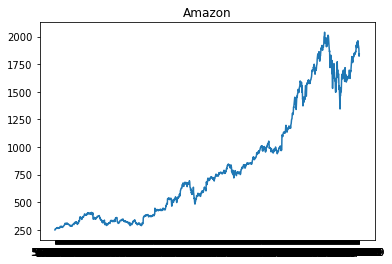

In [31]:
plt.plot(df_2['Date'],df_2['AMZN'])

plt.title('Amazon')

Text(0.5, 1.0, 'DPZ')

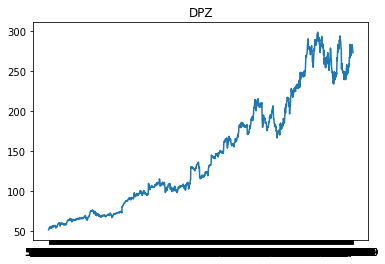

In [32]:
plt.plot(df_2['Date'],df_2['DPZ'])
plt.title('DPZ')

Text(0.5, 1.0, 'BTC')

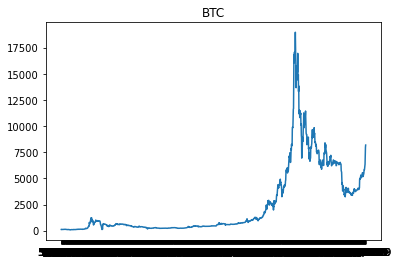

In [33]:
plt.plot(df_2['Date'],df_2['BTC'])
plt.title('BTC')

Text(0.5, 1.0, 'NFLX')

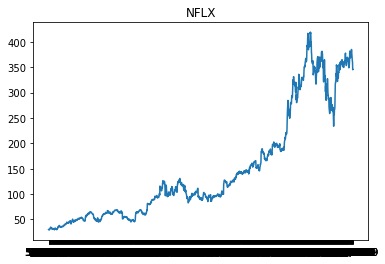

In [34]:
plt.plot(df_2['Date'],df_2['NFLX'])
plt.title('NFLX')

In [35]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

In [36]:
amzn = df_2[['Date','AMZN']]
Xtrain = amzn[:1200]
Xtrain
amzn.index = amzn.Date
amzn.drop('Date', axis=1, inplace=True)
amzn

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(amzn)
scaled_data[:10]
train = amzn[0:1200]
valid = amzn[1200:]
valid
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60: i, 0])
    y_train.append(scaled_data[i,0])
    
    pass


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 10, batch_size=20)

test_inputs = amzn[len(amzn) - len(valid) - 60:].values


test_inputs = test_inputs.reshape(-1,1)
test_inputs  = scaler.transform(test_inputs)


X_test = []
for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)



X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


closing_price = model.predict(X_test)
closing_price[:10]


C:\Users\Bharath\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Epoch 1/10
57/57 [==============================] - 5s 29ms/step - loss: 0.0049
Epoch 2/10
57/57 [==============================] - 2s 30ms/step - loss: 2.0698e-04
Epoch 3/10
57/57 [==============================] - 2s 29ms/step - loss: 2.2197e-04
Epoch 4/10
57/57 [==============================] - 2s 30ms/step - loss: 1.9108e-04
Epoch 5/10
57/57 [==============================] - 2s 30ms/step - loss: 1.8194e-04
Epoch 6/10
57/57 [==============================] - 2s 36ms/step - loss: 1.7020e-04
Epoch 7/10
57/57 [==============================] - 2s 32ms/step - loss: 1.7767e-04
Epoch 8/10
57/57 [==============================] - 2s 32ms/step - loss: 1.6142e-04
Epoch 9/10
57/57 [==============================] - 2s 32ms/step - loss: 1.4367e-04
Epoch 10/10
57/57 [==============================] - 2s 30ms/step - loss: 1.4535e-04


C:\Users\Bharath\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.65612966],
       [0.6592254 ],
       [0.6625952 ],
       [0.6644522 ],
       [0.66227937],
       [0.65720636],
       [0.6524486 ],
       [0.6491711 ],
       [0.64860857],
       [0.65029126]], dtype=float32)

In [37]:
DPZ = df_2[['Date','DPZ']]
Xtrain = DPZ[:1200]
Xtrain
DPZ.index = DPZ.Date
DPZ.drop('Date', axis=1, inplace=True)
DPZ

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(DPZ)
scaled_data[:10]
train = DPZ[0:1200]
valid = DPZ[1200:]
valid
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60: i, 0])
    y_train.append(scaled_data[i,0])
    
    pass


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 10, batch_size=20)

test_inputs = DPZ[len(DPZ) - len(valid) - 60:].values


test_inputs = test_inputs.reshape(-1,1)
test_inputs  = scaler.transform(test_inputs)


X_test = []
for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)



X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


closing_price = model.predict(X_test)
closing_price[:10]


C:\Users\Bharath\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Epoch 1/10
57/57 [==============================] - 5s 32ms/step - loss: 0.0095
Epoch 2/10
57/57 [==============================] - 2s 32ms/step - loss: 4.2647e-04
Epoch 3/10
57/57 [==============================] - 2s 35ms/step - loss: 4.0689e-04
Epoch 4/10
57/57 [==============================] - 2s 35ms/step - loss: 4.1189e-04
Epoch 5/10
57/57 [==============================] - 2s 34ms/step - loss: 3.9038e-04
Epoch 6/10
57/57 [==============================] - 2s 32ms/step - loss: 3.5900e-04
Epoch 7/10
57/57 [==============================] - 2s 32ms/step - loss: 4.1567e-04
Epoch 8/10
57/57 [==============================] - 2s 33ms/step - loss: 3.4787e-04
Epoch 9/10
57/57 [==============================] - 2s 31ms/step - loss: 3.7746e-04
Epoch 10/10
57/57 [==============================] - 2s 34ms/step - loss: 3.4887e-04


C:\Users\Bharath\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.67718077],
       [0.6755668 ],
       [0.6726627 ],
       [0.6696185 ],
       [0.66383547],
       [0.65823585],
       [0.6542307 ],
       [0.6506745 ],
       [0.648077  ],
       [0.6479983 ]], dtype=float32)

In [38]:
BTC = df_2[['Date','BTC']] # BTC
Xtrain = BTC[:1200]
Xtrain
BTC.index = BTC.Date
BTC.drop('Date', axis=1, inplace=True)
BTC

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(BTC)
scaled_data[:10]
train = amzn[0:1200]
valid = amzn[1200:]
valid
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60: i, 0])
    y_train.append(scaled_data[i,0])
    
    pass


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 10, batch_size=20)

test_inputs = BTC[len(BTC) - len(valid) - 60:].values


test_inputs = test_inputs.reshape(-1,1)
test_inputs  = scaler.transform(test_inputs)


X_test = []
for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)



X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


closing_price = model.predict(X_test)
closing_price[:10]


C:\Users\Bharath\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Epoch 1/10
57/57 [==============================] - 5s 36ms/step - loss: 0.0047
Epoch 2/10
57/57 [==============================] - 2s 35ms/step - loss: 0.0014
Epoch 3/10
57/57 [==============================] - 2s 32ms/step - loss: 8.5504e-04
Epoch 4/10
57/57 [==============================] - 2s 36ms/step - loss: 6.2935e-04
Epoch 5/10
57/57 [==============================] - 2s 33ms/step - loss: 6.2652e-04
Epoch 6/10
57/57 [==============================] - 2s 32ms/step - loss: 5.5339e-04
Epoch 7/10
57/57 [==============================] - 2s 35ms/step - loss: 6.1727e-04
Epoch 8/10
57/57 [==============================] - 2s 32ms/step - loss: 5.7413e-04
Epoch 9/10
57/57 [==============================] - 2s 30ms/step - loss: 5.5618e-04
Epoch 10/10
57/57 [==============================] - 2s 31ms/step - loss: 5.8199e-04


C:\Users\Bharath\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.49988875],
       [0.4759781 ],
       [0.45304522],
       [0.43187207],
       [0.41754162],
       [0.41093782],
       [0.41095862],
       [0.4133508 ],
       [0.42251366],
       [0.43785986]], dtype=float32)

In [39]:
NFLX = df_2[['Date','NFLX']]  # Netflix
Xtrain = NFLX[:1200]
Xtrain
NFLX.index = NFLX.Date
NFLX.drop('Date', axis=1, inplace=True)
NFLX

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(NFLX)
scaled_data[:10]
train = NFLX[0:1200]
valid = NFLX[1200:]
valid
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60: i, 0])
    y_train.append(scaled_data[i,0])
    
    pass


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 10, batch_size=20)

test_inputs = NFLX[len(NFLX) - len(valid) - 60:].values


test_inputs = test_inputs.reshape(-1,1)
test_inputs  = scaler.transform(test_inputs)


X_test = []
for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)



X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


closing_price = model.predict(X_test)
closing_price[:10]


C:\Users\Bharath\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Epoch 1/10
57/57 [==============================] - 5s 32ms/step - loss: 0.0032
Epoch 2/10
57/57 [==============================] - 2s 33ms/step - loss: 3.1059e-04
Epoch 3/10
57/57 [==============================] - 2s 32ms/step - loss: 3.1404e-04
Epoch 4/10
57/57 [==============================] - 2s 36ms/step - loss: 2.8859e-04
Epoch 5/10
57/57 [==============================] - 2s 36ms/step - loss: 2.7778e-04
Epoch 6/10
57/57 [==============================] - 2s 40ms/step - loss: 2.5677e-04
Epoch 7/10
57/57 [==============================] - 3s 48ms/step - loss: 2.6535e-04
Epoch 8/10
57/57 [==============================] - 2s 38ms/step - loss: 2.3489e-04
Epoch 9/10
57/57 [==============================] - 2s 33ms/step - loss: 2.4407e-04
Epoch 10/10
57/57 [==============================] - 2s 31ms/step - loss: 2.5758e-04


C:\Users\Bharath\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.6206865 ],
       [0.62031543],
       [0.61875314],
       [0.61596787],
       [0.6090903 ],
       [0.6001931 ],
       [0.59269553],
       [0.5865917 ],
       [0.58371675],
       [0.5864531 ]], dtype=float32)